# Homework 5: K-Fold、Pipeline 和各項評估指標

C111156103, 潘奕濬

## 環境設定

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib_inline

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Import data from UCI machine learning repository

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

## 切割資料集與訓練集

訓練級是用來回測的。

In [4]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Pre-Processing

In [6]:
from typing import Literal, Self
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


class DropNullColumns(BaseEstimator, TransformerMixin):
    transform_type: None | Literal["default", "pandas"]

    def __init__(self, columns: list[str] | None = None):
        self.columns = columns
        self.transform_type = None

    def fit(self, X: pd.DataFrame, _: pd.Series | None = None) -> Self:
        self.null_columns = X.columns[X.isnull().any()]
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
        dropped_X = X.drop(columns=self.null_columns)

        if self.transform_type == "pandas":
            return dropped_X
        else:
            return dropped_X.to_numpy()

    def set_output(
        self, *, transform: None | Literal["default", "pandas"] = None
    ) -> BaseEstimator:
        self.transform_type = transform
        return self


preprocessor = Pipeline(
    [
        # 缺失值處理
        ("drop_cols", DropNullColumns()),
        (
            "encode",
            ColumnTransformer(
                [
                    # label encoding for binary data
                    (
                        "binary",
                        OrdinalEncoder(),
                        [
                            "bruises",
                            "gill-attachment",
                            "gill-spacing",
                            "gill-size",
                            "stalk-shape",
                        ],
                    ),
                    # one-hot encoding for non-binary data
                    (
                        "onehot",
                        OneHotEncoder(dtype="int64", sparse_output=False),
                        [
                            "cap-shape",
                            "cap-surface",
                            "cap-color",
                            "odor",
                            "gill-color",
                            "stalk-surface-above-ring",
                            "stalk-surface-below-ring",
                            "stalk-color-above-ring",
                            "stalk-color-below-ring",
                            "veil-color",
                            "ring-number",
                            "ring-type",
                            "spore-print-color",
                            "population",
                            "habitat",
                        ],
                    ),
                ],
                n_jobs=-1,
                verbose=True
            ),
        ),
        (
            "lda",
            LinearDiscriminantAnalysis(n_components=1),
        ),
    ],
    verbose=True,
)

preprocessor.set_output(transform="pandas")
preprocessor

Pipeline(steps=[('drop_cols', DropNullColumns()),
                ('encode',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('binary', OrdinalEncoder(),
                                                  ['bruises', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'stalk-shape']),
                                                 ('onehot',
                                                  OneHotEncoder(dtype='int64',
                                                                sparse_output=False),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'odor',
                                                   'gill-color',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-color', 'ring-number',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population', 'habitat'])],
                                   verbose=True)),
                ('lda', LinearDiscriminantAnalysis(n_components=1))],
         verbose=True)

## 建立一個最佳模型

LR、RF、SVM、DT、KNN

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

### 邏輯斯回歸

資料集驗證方法：這裡使用 `StratifiedKFold` 搭配 5 折來找出最好的超參數。

```
cv : int, cross-validation generator or an iterable, default=None
    Determines the cross-validation splitting strategy.
    Possible inputs for cv are:

    - None, to use the default 5-fold cross validation,
    - integer, to specify the number of folds in a `(Stratified)KFold`,
    - :term:`CV splitter`,
    - An iterable yielding (train, test) splits as arrays of indices.

    For integer/None inputs, if the estimator is a classifier and ``y`` is
    either binary or multiclass, :class:`StratifiedKFold` is used. In all
    other cases, :class:`KFold` is used. These splitters are instantiated
    with `shuffle=False` so the splits will be the same across calls.

    Refer :ref:`User Guide <cross_validation>` for the various
    cross-validation strategies that can be used here.

    .. versionchanged:: 0.22
        ``cv`` default value if None changed from 3-fold to 5-fold.
```

In [8]:
from sklearn.linear_model import LogisticRegression

base_lr_params = {
    "C": [0.01, 0.1, 1, 10],
    "max_iter": [3000, 5000, 10000],
}
lr_params = [
    {
        **base_lr_params,
        "penalty": ["l2"],
        "solver": ["lbfgs", "sag"],
    },
    {
        **base_lr_params,
        "penalty": ["l1", "l2"],
        "solver": ["saga"],
    },
    {
        **base_lr_params,
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
        "n_jobs": [1],
    },
]

lr_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("standardize", StandardScaler()),  # 邏輯斯回歸在 L1, L2 正則化時需要標準化
        (
            "classifier",
            GridSearchCV(
                LogisticRegression(n_jobs=-1, random_state=42),
                lr_params,
                scoring="accuracy",
                cv=5,
                n_jobs=-1,
                verbose=True,
            ),
        ),
    ],
    verbose=True,
)

assert isinstance(y_train, np.ndarray)
lr_pipeline.fit(X_train, y_train)
lr_classifier: GridSearchCV = lr_pipeline.named_steps['classifier']
print(f"邏輯斯回歸的最佳參數：{lr_classifier.best_params_}")
print(f"邏輯斯回歸的最佳準確率：{lr_classifier.best_score_:.4f}")

[Pipeline] ......... (step 1 of 3) Processing drop_cols, total=   0.0s
[ColumnTransformer] ........ (1 of 2) Processing binary, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing encode, total=   1.1s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   1.1s
[Pipeline] ....... (step 2 of 3) Processing standardize, total=   0.0s
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.0s
邏輯斯回歸的最佳參數：{'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'lbfgs'}
邏輯斯回歸的最佳準確率：0.9998


### 隨機森林

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        (
            "classifier",
            GridSearchCV(
                RandomForestClassifier(random_state=42, n_jobs=-1),
                rf_params,
                scoring="accuracy",
                cv=5,
                n_jobs=-1,
                verbose=True,
            ),
        ),
    ],
    verbose=True,
)

assert isinstance(y_train, np.ndarray)
rf_pipeline.fit(X_train, y_train)
rf_classifier: GridSearchCV = rf_pipeline.named_steps['classifier']
print(f"隨機森林的最佳參數：{rf_classifier.best_params_}")
print(f"隨機森林的最佳準確率：{rf_classifier.best_score_:.4f}")

[Pipeline] ......... (step 1 of 3) Processing drop_cols, total=   0.0s
[ColumnTransformer] ........ (1 of 2) Processing binary, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing encode, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.6s
隨機森林的最佳參數：{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
隨機森林的最佳準確率：0.9998


### SVM Model

In [10]:
from sklearn.svm import SVC

svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

svm_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("standardize", StandardScaler()),  # SVM 高度仰賴特徵縮放
        (
            "classifier",
            GridSearchCV(
                SVC(probability=True, random_state=42),
                svm_params,
                scoring="accuracy",
                cv=5,
                n_jobs=-1,
                verbose=True,
            ),
        ),
    ],
    verbose=True,
)

assert isinstance(y_train, np.ndarray)
svm_pipeline.fit(X_train, y_train)
svm_classifier: GridSearchCV = svm_pipeline.named_steps['classifier']
print(f"SVM 的最佳參數：{svm_classifier.best_params_}")
print(f"SVM 的最佳準確率：{svm_classifier.best_score_:.4f}")

[Pipeline] ......... (step 1 of 3) Processing drop_cols, total=   0.0s
[ColumnTransformer] ........ (1 of 2) Processing binary, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing encode, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   0.1s
[Pipeline] ....... (step 2 of 3) Processing standardize, total=   0.0s
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
SVM 的最佳參數：{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM 的最佳準確率：0.9998


### 決策樹

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

dt_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("standardize", StandardScaler()),  # 雖然 DT 不需標準化，為流程統一保留
        (
            "classifier",
            GridSearchCV(
                DecisionTreeClassifier(random_state=42),
                dt_params,
                scoring="accuracy",
                cv=5,
                n_jobs=-1,
                verbose=True,
            ),
        ),
    ],
    verbose=True,
)

assert isinstance(y_train, np.ndarray)
dt_pipeline.fit(X_train, y_train)
dt_classifier: GridSearchCV = dt_pipeline.named_steps['classifier']
print(f"決策樹的最佳參數：{dt_classifier.best_params_}")
print(f"決策樹的最佳準確率：{dt_classifier.best_score_:.4f}")

[Pipeline] ......... (step 1 of 3) Processing drop_cols, total=   0.0s
[ColumnTransformer] ........ (1 of 2) Processing binary, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing encode, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   0.1s
[Pipeline] ....... (step 2 of 3) Processing standardize, total=   0.0s
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
決策樹的最佳參數：{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
決策樹的最佳準確率：0.9998


### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # 曼哈頓距離與歐幾里得距離
}

knn_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("standardize", StandardScaler()),  # KNN 對尺度敏感，需標準化
        (
            "classifier",
            GridSearchCV(
                KNeighborsClassifier(n_jobs=-1),
                knn_params,
                scoring="accuracy",
                cv=5,
                n_jobs=-1,
                verbose=True,
            ),
        ),
    ],
    verbose=True,
)

assert isinstance(y_train, np.ndarray)
knn_pipeline.fit(X_train, y_train)
knn_classifier: GridSearchCV = knn_pipeline.named_steps['classifier']
print(f"KNN 的最佳參數：{knn_classifier.best_params_}")
print(f"KNN 的最佳準確率：{knn_classifier.best_score_:.4f}")

[Pipeline] ......... (step 1 of 3) Processing drop_cols, total=   0.0s
[ColumnTransformer] ........ (1 of 2) Processing binary, total=   0.0s
[ColumnTransformer] ........ (2 of 2) Processing onehot, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing encode, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   0.1s
[Pipeline] ....... (step 2 of 3) Processing standardize, total=   0.0s
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
KNN 的最佳參數：{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN 的最佳準確率：0.9998


## 針對每個模型做混淆矩陣

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
lr_confusion_matrix = confusion_matrix(y_test, lr_pipeline.predict(X_test))
rf_confusion_matrix = confusion_matrix(y_test, rf_pipeline.predict(X_test))
svm_confusion_matrix = confusion_matrix(y_test, svm_pipeline.predict(X_test))
dt_confusion_matrix = confusion_matrix(y_test, dt_pipeline.predict(X_test))
knn_confusion_matrix = confusion_matrix(y_test, knn_pipeline.predict(X_test))

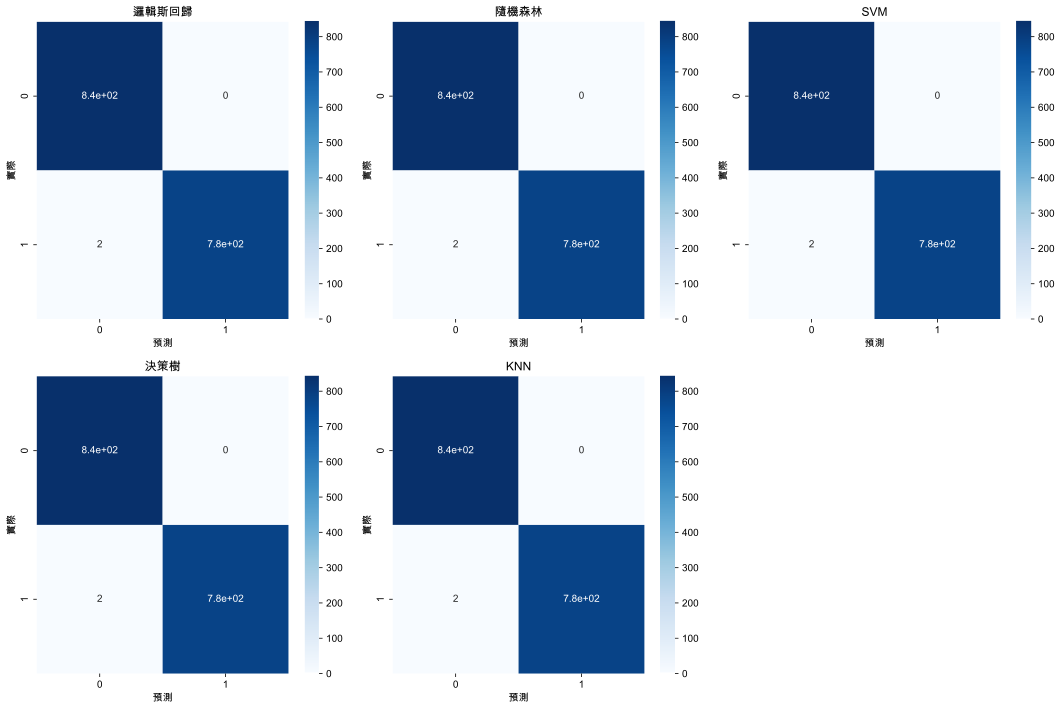

In [15]:
import seaborn as sns

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

confusion_matrixes = {
    "邏輯斯回歸": lr_confusion_matrix,
    "隨機森林": rf_confusion_matrix,
    "SVM": svm_confusion_matrix,
    "決策樹": dt_confusion_matrix,
    "KNN": knn_confusion_matrix,
}

for idx, (name, matrix) in enumerate(confusion_matrixes.items()):
    sns.heatmap(matrix, annot=True, cmap="Blues", ax=ax[idx // 3, idx % 3])
    ax[idx // 3, idx % 3].set_title(name)
    ax[idx // 3, idx % 3].set_xlabel("預測")
    ax[idx // 3, idx % 3].set_ylabel("實際")

ax[1, 2].remove()

fig.tight_layout()
plt.show()


## 測出 Accuracy、Precision、Recall 和 F1

In [16]:
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score


classifiers = {
    "邏輯斯回歸": lr_pipeline,
    "隨機森林": rf_pipeline,
    "SVM": svm_pipeline,
    "決策樹": dt_pipeline,
    "KNN": knn_pipeline,
}

scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1": make_scorer(f1_score),
}

results = []

for name, classifier in classifiers.items():
    table = {
        "Model": name,
    }

    for scorer_name, scorer in scorers.items():
        table[scorer_name] = scorer(classifier, X_test, y_test)

    results.append(table)

results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
results_df.set_index("Model", inplace=True)

results_df

,Accuracy,Precision,Recall,F1
Model,,,,
邏輯斯回歸,0.998769,1.0,0.997446,0.998721
隨機森林,0.998769,1.0,0.997446,0.998721
SVM,0.998769,1.0,0.997446,0.998721
決策樹,0.998769,1.0,0.997446,0.998721
KNN,0.998769,1.0,0.997446,0.998721
